
## DistilBERT Detector to detect DGA domains.
### Author: Abdulkarim Abdulkadir, s4840933


### Load the libraries
We will load the libraries, and check if we are in the Google Colab environment to pip install ktrain and import the drive mount library. This is to make sure that if the notebook is run locally, it will not execute Google Colab environment commands.

In [18]:
import pandas as pd
import numpy as np
import os
import sys
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    ## install modules
    !pip install -q ktrain
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True) 

    ## print
    print('Environment: Google Colaboratory Pro+.')
# import ktrain

Again we check which environment we are to correctly find the location of the data of our domains

In [19]:
if ENV_COLAB:
  dgaLocation = '/content/drive/MyDrive/research/DGA_domains/'
  benignDomains = '/content/drive/MyDrive/research/benign_domains/top-1m.csv'
else:
  dgaLocation = 'data/DGA_domains/'
  benignDomains = 'data/benign_domains/top-1m.csv'

We have a total amount of 19 different DGA types. Including the benign domain data, this will total 20 different types.

In [20]:
dgaDomains = [dga for dga in os.listdir(dgaLocation) if dga.endswith(r".csv")]
print("Total amount of DGA types: ", len(dgaDomains))

Total amount of DGA types:  37


## Load the data into arrays
We will randomly select 110000 samples from the benign domains and 90000 from the dga domains. The ratio between the benign and dga domains will be 55:45. Thus we trimmed our data to a total of 200000 domains to use for training our BERT classifier

In [21]:
dataset = pd.DataFrame()
for i, dga in enumerate(dgaDomains):
  dgaDataFrame = pd.read_csv(dgaLocation + dga)
  dgaDataFrame.insert(1,'type',dga.split(".")[0])
  dgaDataFrame.insert(2,'class',1)
  dataset = dataset.append(dgaDataFrame, ignore_index=True)
benignDataFrame = pd.read_csv(benignDomains)
benignDataFrame.insert(1, 'type', 'benign')
benignDataFrame.insert(2, 'class', 0)
dataset = dataset.append(benignDataFrame[:200000], ignore_index=True)
dataset = dataset.reset_index(drop=True)

In [22]:
print("Total amount of DGA domains: ", dataset['class'].value_counts()[1])
print("Total amount of benign domains: ", dataset['class'].value_counts()[0])
print("Total amount of domains: ", len(dataset))
if ENV_COLAB:
  dataset.to_csv('/content/drive/MyDrive/research/dataset', index=False)
else:
  dataset.to_csv('data/dataset', index=False)

Total amount of DGA domains:  184765
Total amount of benign domains:  200000
Total amount of domains:  384765


We will split our data into random train and test subsets. Our test size will be 25%. Our random_state that control the randon number generated has to be given. Popular seeds are 42 or 0. We chose 42 for obvious reasons.

In [32]:
if ENV_COLAB:
  dataset = pd.read_csv('/content/drive/MyDrive/research/dataset')
else:
  dataset = pd.read_csv('data/dataset')
X = dataset['domain']

labels = dataset['class']
class_names = labels.unique()
x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.25, random_state=42)

Display the first 10 and last 10 data in our dataset.

In [33]:
display(dataset.head(10).append(dataset.tail(10)))

,domain,type,class
0,fliffmdhwrdjb.org,locky,1
1,oqfyajoxgqnf.pw,locky,1
2,pnycpjwcw.pl,locky,1
3,bxicshg.info,locky,1
4,bamiitcnugeuemxgt.work,locky,1
5,yuldhyhtaiqgjrpfk.work,locky,1
6,irjhglaihb.xyz,locky,1
7,oxmblinqcstkj.xyz,locky,1
8,phudexoqds.xyz,locky,1
9,fqsfemovqshfcc.su,locky,1


In [36]:
print("Size of training set: %s" % (len(x_train)))
print("Size of validation set: %s" % (len(x_test)))

Size of training set: 288573
Size of validation set: 96192


In [37]:
print(x_train.head(10))

                        domain     type  class
284318      springeronline.com   benign      0
271248            indianss.org   benign      0
362013                pnsn.org   benign      0
274681           mtexpress.com   benign      0
106241     odonxl1egulqj4t.com  shiotob      1
356934  chambre-agriculture.fr   benign      0
251804                  s.coop   benign      0
207205      taishinbank.com.tw   benign      0
324992              neu.edu.vn   benign      0
46367           lyiemychun.com   fobber      1


We list all the text models that ktrain offers. For our research we will use the distilbert model. Which is a faster, smaller and distilled version of BERT. 

In [ ]:
ktrain.text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


In [ ]:
model_name = 'distilbert-base-uncased'
t = ktrain.text.Transformer(model_name, class_names=labels.unique(),
                     maxlen=350)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Naming our pre-process train and validation dataset respectively.

In [ ]:
train = t.preprocess_train(x_train.tolist(), y_train.to_list())

val = t.preprocess_test(x_test.tolist(), y_test.to_list())
model = t.get_classifier()

preprocessing train...
language: en
train sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

We will find a good learning rate using the learning rate range test to provide valuable information about an optimal learnign rate. To point has to be chosen at which the loss starts descending and the point at which the loss stops descending or becomes ragged. For BERT and DistilBERT models the typical learning rate is between 5e-5 and 2e-5.

In [ ]:
learner = ktrain.get_learner(model,
                       train_data=train,
                       val_data=val,
                       batch_size=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/4
25000/25000 [==============================] - 3781s 150ms/step - loss: 0.1452 - accuracy: 0.9468
Epoch 2/4
25000/25000 [==============================] - 2056s 81ms/step - loss: 0.0797 - accuracy: 0.9664


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


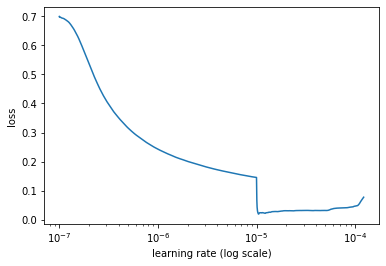

In [ ]:
learner.lr_find(max_epochs=4)
learner.lr_plot()

Based on the plot above we choose 3e-5 as our learning rate. We will fit a model follwing the 1cycle policy.

In [ ]:
learner.fit_onecycle(3e-5, 4)



begin training using onecycle policy with max lr of 3e-05...
Epoch 1/4
25000/25000 [==============================] - 3861s 153ms/step - loss: 0.0389 - accuracy: 0.9874 - val_loss: 0.0181 - val_accuracy: 0.9944
Epoch 2/4
25000/25000 [==============================] - 3861s 154ms/step - loss: 0.0163 - accuracy: 0.9956 - val_loss: 0.0292 - val_accuracy: 0.9947
Epoch 3/4
25000/25000 [==============================] - 3869s 154ms/step - loss: 0.0091 - accuracy: 0.9976 - val_loss: 0.0166 - val_accuracy: 0.9965
Epoch 4/4
25000/25000 [==============================] - 3888s 155ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0147 - val_accuracy: 0.9972


Save the learned model to location, to reuse the model without having to learn our dataset again.

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=t)
if ENV_COLAB:
  predictor.save('/content/drive/MyDrive/research/model/')
else: 
  predictor.save('model/')

View observations in learner with top losses in validation dataset. 

In [ ]:
learner.view_top_losses(preproc=t, n=1, val_data=None)

----------
id:29028 | loss:12.09 | true:1 | pred:0)



We will cross-check the model with the validation(test) data, we can use the validate method assigned to the learner instance of the model. The results will be displayed in precision, recall and f1 score.

In [ ]:
learner.validate(val_data=val,class_names=t.get_classes())

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27737
           1       1.00      1.00      1.00     22263

    accuracy                           1.00     50000
   macro avg       1.00      1.00      1.00     50000
weighted avg       1.00      1.00      1.00     50000



array([[27674,    63],
       [   77, 22186]])

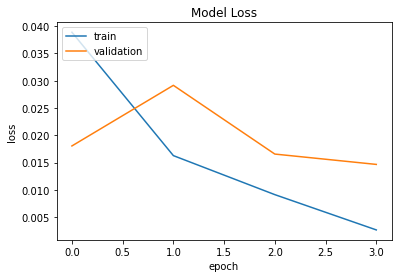

In [ ]:
learner.plot()

In [ ]:
valid_preds = learner.predict()
len(valid_preds), dataset.shape, valid_preds[:5]

(50000, (200000, 3), array([[6.0326261e-06, 9.9999392e-01],
        [9.9999654e-01, 3.3981382e-06],
        [9.9999535e-01, 4.6324981e-06],
        [9.9999630e-01, 3.6541069e-06],
        [1.6295456e-04, 9.9983704e-01]], dtype=float32))

### Model prediction on validation data

Load the saved predictor model to predict on the validation data.

In [ ]:
if ENV_COLAB:
  predictor = ktrain.load_predictor('/content/drive/MyDrive/research/model/')
else:
  predictor = ktrain.load_predictor('model/')
learner = ktrain.get_learner(predictor.model, train_data = train, val_data = val, batch_size = 12)


In [ ]:
predictor.get_classes()

[0, 1]

In [ ]:
print(type(val))
# val = t.preprocess_test(x_test.tolist(), y_test.to_list())
x_fake = pd.Series(['hooghelandt.nl', 'radboud.nl', 'cryptojedi.org', 'https://ais.usvisa-info.com/', '000directory.com.ar', '01-telecharger.com', '1001tur.ru', '02022222222.com', 'ovenrenthighlightstablerefuse.com', 'rowrepeatwakeassociatebox.com', 'iucyyekyuksiewqo.org', 'owwxxonkponu.co', 'myeqiiookymyokqs.org'])
y_fake = pd.Series([1,1,1,1,1,1,1,1,0,0,0,0,0])
x_test = x_test.append(x_fake)
y_test = y_test.append(y_fake)

print(x_test.tail(13))
print(y_test.tail(13))


<class 'ktrain.text.preprocessor.TransformerDataset'>
0                        hooghelandt.nl
1                            radboud.nl
2                        cryptojedi.org
3          https://ais.usvisa-info.com/
4                   000directory.com.ar
5                    01-telecharger.com
6                            1001tur.ru
7                       02022222222.com
8     ovenrenthighlightstablerefuse.com
9         rowrepeatwakeassociatebox.com
10                 iucyyekyuksiewqo.org
11                      owwxxonkponu.co
12                 myeqiiookymyokqs.org
dtype: object
0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     0
9     0
10    0
11    0
12    0
dtype: int64


In [ ]:
val = t.preprocess_test(x_fake.tolist(), y_fake.to_list())
learner.validate(val_data=val,class_names=t.get_classes())

preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       5.0
           1       0.00      0.00      0.00       8.0

    accuracy                           0.00      13.0
   macro avg       0.00      0.00      0.00      13.0
weighted avg       0.00      0.00      0.00      13.0



array([[0, 5],
       [8, 0]])

Highlight the text of the validation sample to explain the prediction.

In [ ]:
from sklearn.metrics import accuracy_score
pred=predictor.predict(x_test.to_list())
acc=accuracy_score(y_test.to_list(),pred)

In [ ]:
print(acc)

0.9964227902236256


Predict on benign and dga domains that are not in our validation data or training data to check our classifier resilliance to new data.

In [ ]:
print("Benign domains: ")
print(predictor.predict('hooghelandt.nl'))
print(predictor.predict('radboud.nl'))
print(predictor.predict('cryptojedi.org'))
print(predictor.predict('https://ais.usvisa-info.com/'))
print(predictor.predict('000directory.com.ar'))
print(predictor.predict('01-telecharger.com'))
print(predictor.predict('1001tur.ru'))
print(predictor.predict('02022222222.com'))
print("DGA domains: ")
print(predictor.predict('ovenrenthighlightstablerefuse.com'))
print(predictor.predict('rowrepeatwakeassociatebox.com'))
print(predictor.predict('rowrepeatwakeassociatebox.com'))
print(predictor.predict('iucyyekyuksiewqo.org'))
print(predictor.predict('myeqiiookymyokqs.org'))
print(predictor.predict('owwxxonkponu.co'))

Benign domains: 
0
0
0
0
0
0
0
0
DGA domains: 
1
1
1
1
1
1


In [ ]:
if ENV_COLAB:
  validation_data_location = '/content/drive/MyDrive/research/validation_data.csv'
else:
  validation_data_location = 'validation_data.csv'
validation_dataset = pd.read_csv(validation_data_location)
validation_dataset = validation_dataset.drop(labels='number',axis=1)
validation_dataset = validation_dataset.drop(labels=range(500000,1000000),axis=0)
validation_dataset = validation_dataset.drop(labels=range(1500000,1800000),axis=0)
validation_dataset.reset_index()
validation_dataset = validation_dataset.replace(to_replace='legit', value=0)
validation_dataset = validation_dataset.replace(to_replace='conficker', value=1)
validation_dataset = validation_dataset.replace(to_replace='cryptolocker', value=1)
validation_dataset = validation_dataset.replace(to_replace='zeus', value=1)
validation_dataset = validation_dataset.replace(to_replace='pushdo', value=1)
validation_dataset = validation_dataset.replace(to_replace='rovnix', value=1)
validation_dataset = validation_dataset.replace(to_replace='tinba', value=1)
validation_dataset = validation_dataset.replace(to_replace='matsnu', value=1)
validation_dataset = validation_dataset.replace(to_replace='ramdo', value=1)


print(validation_dataset)
for data in validation_dataset:
  print(data)


                               domain  class
0                          google.com      0
1                        facebook.com      0
2                         youtube.com      0
3                           baidu.com      0
4                           yahoo.com      0
...                               ...    ...
1499995    byaaemigrationforthese.com      1
1499996  wethesenecessarypursuing.com      1
1499997   tyrantofonoverarmstrial.com      1
1499998    absolutestagepartsthey.com      1
1499999      themrepeatedsuchatof.com      1

[1000000 rows x 2 columns]
domain
class


In [ ]:
false = 0
true = 0
for idx, row in validation_dataset.iterrows():
  if predictor.predict(row['domain']) == row['class']:
    true = true + 1
  else:
    false = false + 1
